El objetivo de este código es hacer una partición de los datos por sujeto. Se reserva un sujeto para test, otro para validación, y el resto para entrenar. Luego se implementa un mlp.



In [19]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


Importo las librerías y los datos

In [20]:
!pip install comet_ml
import matplotlib.pyplot as plt
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import joblib
import seaborn as sns
from comet_ml import Experiment

sys.path.append('/content/drive/My Drive/repo_tesis/lib')
import classes as cl

features = load("/content/drive/My Drive/repo_tesis/data/FEATURES_W200_I50.joblib")
label = load("/content/drive/My Drive/repo_tesis/data/label_W200_I50.joblib")

Construyo cada conjunto de datos haciendo la división por sujeto.


*   Dos sujetos para test.
*   Dos sujetos para validación.
*   El resto para entrenamiento.

Esto lo dejé así por defecto pero puede modificarse fácilmente.





In [ ]:
# Calculo la cantidad de sujetos
label = np.array(label)
cantSujetos = np.max(label[:, 2])

# Identifico al sujeto que voy a usar para testear
sujeto_test = 1

# Hago un sorteo a ver que sujeto va para cada conjunto
sorteo = np.random.permutation(cantSujetos) + 1

# Elimino del sorteo el sujeto test porque es el que estoy fijando
sorteo_sin_test = np.delete(sorteo, np.where(sorteo == sujeto_test))

# El primer sujeto del sorteo va a test, el segundo a val y el resto a train
indices_test = list(np.where(label[:, 2]==sujeto_test)[0]) # list(np.where(label[:, 2]==sorteo[0])[0])
indices_val = list(np.where(label[:, 2]==sorteo_sin_test[0])[0]) # indices_val = list(np.where(label[:, 2]==sorteo[2])[0])

# indices_test.extend(list(np.where(label[:, 2]==sorteo[1])[0]))
indices_val.extend(list(np.where(label[:, 2]==sorteo_sin_test[1])[0]))

indices_train = []
for j in sorteo_sin_test[2:]:
    indices_train.extend(np.where(label[:, 2]==j)[0])

# lo paso a numpy array para poder definir de forma mas comoda los conjuntos de train test y val
features = np.array(features)

X_train = features[indices_train, :]
y_train = label[indices_train, 1]
X_val = features[indices_val, :]
y_val = label[indices_val, 1]
X_test =  features[indices_test, :]
y_test = label[indices_test, 1]

Entreno una red neuronal de arquitectura 250-500-250.

In [ ]:

# Quiero calcular el tiempo que demora en entrenarse el algoritmo
start_time = time.time()

# Parametros de entrada de la red neuronal que tenemos que definir
# Definimos a mano la cantidad de features
featureNum = 15
chNum = 16
# Numero de columnas que va a haber en features
inputDim = chNum*featureNum
# Numero de gestos contando el reposo
clasNum = np.max(label[:, 1]) + 1

# Architecture 250 - 500 - 250
red = cl.Clasificador(model= "mlp", arch = [250,500,250], catNum = clasNum, featureNum = inputDim)
red.train(X_train, y_train, X_val, y_val)

end_time = time.time()
training_time = end_time - start_time

# Calculo las etiquetas predecidas por el modelo
y_pred = red.predict(X_test)

Epoch 1/50
2854/2854 [==============================] - 22s 7ms/step - loss: 1.5848 - accuracy: 0.4477 - val_loss: 2.2569 - val_accuracy: 0.3256
Epoch 2/50
2854/2854 [==============================] - 22s 8ms/step - loss: 1.2604 - accuracy: 0.5609 - val_loss: 2.6579 - val_accuracy: 0.3094
Epoch 3/50
2854/2854 [==============================] - 20s 7ms/step - loss: 1.1136 - accuracy: 0.6102 - val_loss: 3.1171 - val_accuracy: 0.2761
Epoch 4/50
2854/2854 [==============================] - 21s 7ms/step - loss: 1.0051 - accuracy: 0.6520 - val_loss: 3.0385 - val_accuracy: 0.3061
Epoch 5/50
2854/2854 [==============================] - 21s 7ms/step - loss: 0.9250 - accuracy: 0.6773 - val_loss: 3.5528 - val_accuracy: 0.2973
Epoch 6/50
2854/2854 [==============================] - 22s 8ms/step - loss: 0.8603 - accuracy: 0.6994 - val_loss: 3.8612 - val_accuracy: 0.2674
Epoch 7/50
2854/2854 [==============================] - 22s 8ms/step - loss: 0.7999 - accuracy: 0.7158 - val_loss: 3.7266 - val_ac

Voy a guardar el clasificador, y evaluar distintas métricas: accuracy, precision y recall. Voy a hacer una matriz de confusión.
Por otra parte, voy a guardar la partición de los datos para hacer reproducible el experimento.

174/174 [==============================] - 1s 3ms/step
Accuracy: 0.2641237855343649
Precision: 0.25986499954738923
Recall: 0.2641237855343649


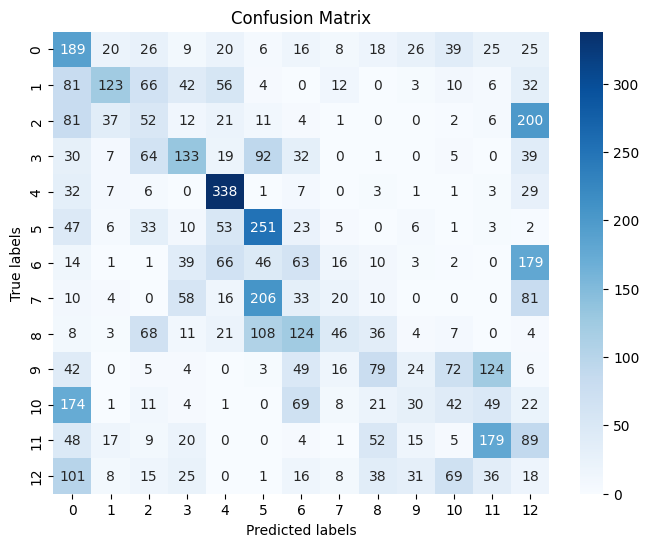

<Figure size 640x480 with 0 Axes>

In [ ]:
nombre = 'baseline_mlp_sep_sub1_testing'

# Guardar el modelo entrenado en un archivo
joblib.dump(red, nombre + '.pkl')

# Predecir en el conjunto de test
y_pred = red.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Guardar la imagen de la matriz de confusión
plt.savefig("confusion_matrix.png")

Voy a guardar las métricas calculadas en un experimento en Comet


In [ ]:

# Conectar con Comet
API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO' # Se puede encontrar en Settings(Arriba a la derecha en Comet)

# Crear un experimento con mi API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['baseline', 'mlp', 'sep_sub', 'choose_test']) # Tags

exp.log_metric("accuracy", accuracy)
exp.log_metric("precision", precision)
exp.log_metric("recall", recall)
exp.log_metric("training_time", training_time)
exp.log_confusion_matrix(y_test, y_pred)
exp.log_parameter("partition_array", sorteo)   # Guarda el arreglo en el experimento
exp.log_text("Se fija el sujeto de test y se sortea el resto. El primer sujeto del sorteo es el de validación.")   # Comentario del experimento

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/ebbab3d682f44c3d8c3d024880d21779



{'web': 'https://www.comet.com/api/asset/download?assetId=fd2f4cd3d2324cbab71c9567f9a767d5&experimentKey=ebbab3d682f44c3d8c3d024880d21779',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=fd2f4cd3d2324cbab71c9567f9a767d5&experimentKey=ebbab3d682f44c3d8c3d024880d21779',
 'assetId': 'fd2f4cd3d2324cbab71c9567f9a767d5'}

In [ ]:
# Subir el modelo
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/ebbab3d682f44c3d8c3d024880d21779
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.2641237855343649
COMET INFO:     precision     : 0.25986499954738923
COMET INFO:     recall        : 0.2641237855343649
COMET INFO:     training_time : 1051.2417647838593
COMET INFO:   Others:
COMET INFO:     Name : baseline_mlp_sep_sub1_testing
COMET INFO:   Parameters:
COMET INFO:     partition_array : [ 9  7  4  5  8 10  1  2  6  3]
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:   

Junto todo en un bloque para armar un for que haga todos los experimentos

In [21]:
for i in range(2,11):
  label = np.array(label)
  cantSujetos = np.max(label[:, 2])
  sujeto_test = i
  sorteo = np.random.permutation(cantSujetos) + 1
  sorteo_sin_test = np.delete(sorteo, np.where(sorteo == sujeto_test))
  indices_test = list(np.where(label[:, 2]==sujeto_test)[0])
  indices_val = list(np.where(label[:, 2]==sorteo_sin_test[0])[0])
  indices_val.extend(list(np.where(label[:, 2]==sorteo_sin_test[1])[0]))

  indices_train = []
  for j in sorteo_sin_test[2:]:
      indices_train.extend(np.where(label[:, 2]==j)[0])
  features = np.array(features)

  X_train = features[indices_train, :]
  y_train = label[indices_train, 1]
  X_val = features[indices_val, :]
  y_val = label[indices_val, 1]
  X_test =  features[indices_test, :]
  y_test = label[indices_test, 1]

  start_time = time.time()

  featureNum = 15
  chNum = 16
  inputDim = chNum*featureNum
  clasNum = np.max(label[:, 1]) + 1

  # Architecture 250 - 500 - 250
  red = cl.Clasificador(model= "mlp", arch = [250,500,250], catNum = clasNum, featureNum = inputDim)
  red.train(X_train, y_train, X_val, y_val)

  end_time = time.time()
  training_time = end_time - start_time
  y_pred = red.predict(X_test)

  nombre = 'baseline_mlp_sep_sub' + str(i) + '_testing'

  joblib.dump(red, nombre + '.pkl')

  y_pred = red.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.savefig("confusion_matrix.png")

  API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

  exp = Experiment(api_key=API_KEY,
                  project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                  auto_param_logging=False)
  exp.set_name(nombre) # Nombre de este experimento
  exp.add_tags(['baseline', 'mlp', 'sep_sub', 'choose_test']) # Tags

  exp.log_metric("accuracy", accuracy)
  exp.log_metric("precision", precision)
  exp.log_metric("recall", recall)
  exp.log_metric("training_time", training_time)
  exp.log_confusion_matrix(y_test, y_pred)
  exp.log_parameter("partition_array", sorteo)   # Guarda el arreglo en el experimento
  exp.log_text("Se fija el sujeto de test y se sortea el resto. El primer sujeto del sorteo es el de validación.")   # Comentario del experimento
  exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
  exp.end()

Epoch 1/50
2867/2867 [==============================] - 53s 18ms/step - loss: 1.5966 - accuracy: 0.4529 - val_loss: 2.3149 - val_accuracy: 0.2957
Epoch 2/50
2867/2867 [==============================] - 31s 11ms/step - loss: 1.2854 - accuracy: 0.5617 - val_loss: 2.8179 - val_accuracy: 0.2816
Epoch 3/50
2867/2867 [==============================] - 19s 7ms/step - loss: 1.1379 - accuracy: 0.6080 - val_loss: 3.1566 - val_accuracy: 0.2923
Epoch 4/50
2867/2867 [==============================] - 26s 9ms/step - loss: 1.0274 - accuracy: 0.6436 - val_loss: 3.5902 - val_accuracy: 0.2916
Epoch 5/50
2867/2867 [==============================] - 22s 8ms/step - loss: 0.9397 - accuracy: 0.6712 - val_loss: 3.6939 - val_accuracy: 0.2773
Epoch 6/50
2867/2867 [==============================] - 20s 7ms/step - loss: 0.8718 - accuracy: 0.6961 - val_loss: 4.0842 - val_accuracy: 0.2762
Epoch 7/50
2867/2867 [==============================] - 20s 7ms/step - loss: 0.8122 - accuracy: 0.7173 - val_loss: 4.1206 - val_

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/0f33c10cafa84ff7b386cbd1be0a8e53

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/0f33c10cafa84ff7b386cbd1be0a8e53
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.3332317537711412
COMET INFO:     precision     : 0.

Epoch 1/50
2846/2846 [==============================] - 20s 7ms/step - loss: 1.6135 - accuracy: 0.4323 - val_loss: 1.9141 - val_accuracy: 0.3791
Epoch 2/50
2846/2846 [==============================] - 19s 7ms/step - loss: 1.2577 - accuracy: 0.5623 - val_loss: 1.9649 - val_accuracy: 0.3461
Epoch 3/50
2846/2846 [==============================] - 19s 7ms/step - loss: 1.0950 - accuracy: 0.6201 - val_loss: 2.0662 - val_accuracy: 0.3578
Epoch 4/50
2846/2846 [==============================] - 19s 7ms/step - loss: 0.9793 - accuracy: 0.6584 - val_loss: 2.1404 - val_accuracy: 0.3590
Epoch 5/50
2846/2846 [==============================] - 19s 7ms/step - loss: 0.8897 - accuracy: 0.6868 - val_loss: 2.4426 - val_accuracy: 0.3224
Epoch 6/50
2846/2846 [==============================] - 22s 8ms/step - loss: 0.8167 - accuracy: 0.7145 - val_loss: 2.5175 - val_accuracy: 0.3325
Epoch 7/50
2846/2846 [==============================] - 18s 6ms/step - loss: 0.7586 - accuracy: 0.7338 - val_loss: 2.4012 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/150e8fa9154a45adaa0b93b2fea07eab

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/150e8fa9154a45adaa0b93b2fea07eab
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.26580226904376014
COMET INFO:     precision     : 0

Epoch 1/50
2783/2783 [==============================] - 21s 7ms/step - loss: 1.5872 - accuracy: 0.4516 - val_loss: 2.1990 - val_accuracy: 0.3056
Epoch 2/50
2783/2783 [==============================] - 18s 7ms/step - loss: 1.2494 - accuracy: 0.5693 - val_loss: 2.4056 - val_accuracy: 0.2971
Epoch 3/50
2783/2783 [==============================] - 18s 6ms/step - loss: 1.0898 - accuracy: 0.6251 - val_loss: 2.3284 - val_accuracy: 0.3285
Epoch 4/50
2783/2783 [==============================] - 20s 7ms/step - loss: 0.9774 - accuracy: 0.6608 - val_loss: 2.5209 - val_accuracy: 0.3068
Epoch 5/50
2783/2783 [==============================] - 19s 7ms/step - loss: 0.8895 - accuracy: 0.6881 - val_loss: 2.6157 - val_accuracy: 0.3061
Epoch 6/50
2783/2783 [==============================] - 19s 7ms/step - loss: 0.8184 - accuracy: 0.7144 - val_loss: 2.6522 - val_accuracy: 0.3269
Epoch 7/50
2783/2783 [==============================] - 20s 7ms/step - loss: 0.7588 - accuracy: 0.7341 - val_loss: 3.0673 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/d6e7dd5540f1492895759729694fb058

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/d6e7dd5540f1492895759729694fb058
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.2693525179856115
COMET INFO:     precision     : 0.

Epoch 1/50
2873/2873 [==============================] - 19s 6ms/step - loss: 1.5934 - accuracy: 0.4334 - val_loss: 2.1236 - val_accuracy: 0.3571
Epoch 2/50
2873/2873 [==============================] - 19s 7ms/step - loss: 1.2690 - accuracy: 0.5566 - val_loss: 2.3957 - val_accuracy: 0.3142
Epoch 3/50
2873/2873 [==============================] - 19s 6ms/step - loss: 1.1102 - accuracy: 0.6133 - val_loss: 2.5697 - val_accuracy: 0.3214
Epoch 4/50
2873/2873 [==============================] - 18s 6ms/step - loss: 0.9977 - accuracy: 0.6519 - val_loss: 2.9298 - val_accuracy: 0.3011
Epoch 5/50
2873/2873 [==============================] - 20s 7ms/step - loss: 0.9075 - accuracy: 0.6845 - val_loss: 3.1751 - val_accuracy: 0.3056
Epoch 6/50
2873/2873 [==============================] - 18s 6ms/step - loss: 0.8430 - accuracy: 0.7037 - val_loss: 3.4143 - val_accuracy: 0.2747
Epoch 7/50
2873/2873 [==============================] - 20s 7ms/step - loss: 0.7809 - accuracy: 0.7276 - val_loss: 3.7539 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/48c487b0697a48469ddc569852eb3f7b

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/48c487b0697a48469ddc569852eb3f7b
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.29042192793347704
COMET INFO:     precision     : 0

Epoch 1/50
2909/2909 [==============================] - 21s 7ms/step - loss: 1.5481 - accuracy: 0.4571 - val_loss: 2.5848 - val_accuracy: 0.2973
Epoch 2/50
2909/2909 [==============================] - 19s 6ms/step - loss: 1.2445 - accuracy: 0.5631 - val_loss: 3.0785 - val_accuracy: 0.3081
Epoch 3/50
2909/2909 [==============================] - 21s 7ms/step - loss: 1.0873 - accuracy: 0.6185 - val_loss: 3.3260 - val_accuracy: 0.2711
Epoch 4/50
2909/2909 [==============================] - 20s 7ms/step - loss: 0.9789 - accuracy: 0.6566 - val_loss: 3.7963 - val_accuracy: 0.2685
Epoch 5/50
2909/2909 [==============================] - 20s 7ms/step - loss: 0.8953 - accuracy: 0.6855 - val_loss: 4.4242 - val_accuracy: 0.2403
Epoch 6/50
2909/2909 [==============================] - 20s 7ms/step - loss: 0.8249 - accuracy: 0.7096 - val_loss: 4.7910 - val_accuracy: 0.2487
Epoch 7/50
2909/2909 [==============================] - 19s 6ms/step - loss: 0.7720 - accuracy: 0.7270 - val_loss: 4.7768 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/19ef7fa4ef424f6b8569224d675deda7

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/19ef7fa4ef424f6b8569224d675deda7
COMET INFO:   Metrics:
COMET INFO:     accura

Epoch 1/50
2854/2854 [==============================] - 20s 7ms/step - loss: 1.5937 - accuracy: 0.4370 - val_loss: 2.2528 - val_accuracy: 0.3200
Epoch 2/50
2854/2854 [==============================] - 18s 6ms/step - loss: 1.2649 - accuracy: 0.5582 - val_loss: 2.4631 - val_accuracy: 0.3414
Epoch 3/50
2854/2854 [==============================] - 19s 7ms/step - loss: 1.1021 - accuracy: 0.6146 - val_loss: 2.7810 - val_accuracy: 0.3017
Epoch 4/50
2854/2854 [==============================] - 18s 6ms/step - loss: 0.9890 - accuracy: 0.6534 - val_loss: 2.9959 - val_accuracy: 0.3108
Epoch 5/50
2854/2854 [==============================] - 18s 6ms/step - loss: 0.8970 - accuracy: 0.6868 - val_loss: 3.3631 - val_accuracy: 0.2773
Epoch 6/50
2854/2854 [==============================] - 19s 7ms/step - loss: 0.8260 - accuracy: 0.7113 - val_loss: 3.3761 - val_accuracy: 0.3042
Epoch 7/50
2854/2854 [==============================] - 18s 6ms/step - loss: 0.7694 - accuracy: 0.7307 - val_loss: 3.7378 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/2314d2bf6a8d4156a6537a35c5a6ca44

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/2314d2bf6a8d4156a6537a35c5a6ca44
COMET INFO:   Metrics:
COMET INFO:     accura

Epoch 1/50
2843/2843 [==============================] - 19s 6ms/step - loss: 1.5946 - accuracy: 0.4426 - val_loss: 2.1433 - val_accuracy: 0.3359
Epoch 2/50
2843/2843 [==============================] - 19s 7ms/step - loss: 1.2542 - accuracy: 0.5696 - val_loss: 2.4149 - val_accuracy: 0.3475
Epoch 3/50
2843/2843 [==============================] - 19s 7ms/step - loss: 1.1065 - accuracy: 0.6167 - val_loss: 2.7911 - val_accuracy: 0.3299
Epoch 4/50
2843/2843 [==============================] - 18s 6ms/step - loss: 1.0034 - accuracy: 0.6518 - val_loss: 3.0036 - val_accuracy: 0.3333
Epoch 5/50
2843/2843 [==============================] - 19s 7ms/step - loss: 0.9155 - accuracy: 0.6800 - val_loss: 2.8813 - val_accuracy: 0.3393
Epoch 6/50
2843/2843 [==============================] - 18s 6ms/step - loss: 0.8454 - accuracy: 0.7047 - val_loss: 3.2180 - val_accuracy: 0.3056
Epoch 7/50
2843/2843 [==============================] - 17s 6ms/step - loss: 0.7863 - accuracy: 0.7255 - val_loss: 3.6495 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/e61bd48cf8ad485d849a62f84727a889

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/e61bd48cf8ad485d849a62f84727a889
COMET INFO:   Metrics:
COMET INFO:     accura

Epoch 1/50
2762/2762 [==============================] - 21s 7ms/step - loss: 1.5342 - accuracy: 0.4495 - val_loss: 2.1374 - val_accuracy: 0.3298
Epoch 2/50
2762/2762 [==============================] - 20s 7ms/step - loss: 1.1873 - accuracy: 0.5759 - val_loss: 2.4710 - val_accuracy: 0.3060
Epoch 3/50
2762/2762 [==============================] - 18s 7ms/step - loss: 1.0387 - accuracy: 0.6323 - val_loss: 2.5789 - val_accuracy: 0.2819
Epoch 4/50
2762/2762 [==============================] - 18s 7ms/step - loss: 0.9278 - accuracy: 0.6738 - val_loss: 2.8562 - val_accuracy: 0.2526
Epoch 5/50
2762/2762 [==============================] - 20s 7ms/step - loss: 0.8483 - accuracy: 0.6999 - val_loss: 3.0814 - val_accuracy: 0.2586
Epoch 6/50
2762/2762 [==============================] - 19s 7ms/step - loss: 0.7753 - accuracy: 0.7250 - val_loss: 3.1265 - val_accuracy: 0.2551
Epoch 7/50
2762/2762 [==============================] - 18s 7ms/step - loss: 0.7188 - accuracy: 0.7443 - val_loss: 3.2673 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/812f674a1e064a29b3b0bdc68f61d7f9

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/812f674a1e064a29b3b0bdc68f61d7f9
COMET INFO:   Metrics:
COMET INFO:     accura

Epoch 1/50
2780/2780 [==============================] - 21s 7ms/step - loss: 1.5013 - accuracy: 0.4743 - val_loss: 2.1564 - val_accuracy: 0.3377
Epoch 2/50
2780/2780 [==============================] - 21s 7ms/step - loss: 1.1969 - accuracy: 0.5782 - val_loss: 2.4719 - val_accuracy: 0.3163
Epoch 3/50
2780/2780 [==============================] - 18s 7ms/step - loss: 1.0441 - accuracy: 0.6338 - val_loss: 2.5794 - val_accuracy: 0.2878
Epoch 4/50
2780/2780 [==============================] - 20s 7ms/step - loss: 0.9365 - accuracy: 0.6700 - val_loss: 2.7854 - val_accuracy: 0.2926
Epoch 5/50
2780/2780 [==============================] - 23s 8ms/step - loss: 0.8522 - accuracy: 0.6957 - val_loss: 3.1091 - val_accuracy: 0.2531
Epoch 6/50
2780/2780 [==============================] - 20s 7ms/step - loss: 0.7823 - accuracy: 0.7206 - val_loss: 3.2656 - val_accuracy: 0.2674
Epoch 7/50
2780/2780 [==============================] - 20s 7ms/step - loss: 0.7255 - accuracy: 0.7419 - val_loss: 3.6669 - val_ac

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, lightgbm, tensorflow, tensorboard, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/16406496598d4e38bc29c987f7a5b8e9

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/16406496598d4e38bc29c987f7a5b8e9
COMET INFO:   Metrics:
COMET INFO:     accura

<Figure size 640x480 with 0 Axes>